# **Project No:** *5*</font><br/>
# **Title:** <font color='red'>*Lumen Power-Grid & Banknote Authenticity Detection via Least Squares Method ("Introduction to Applied Linear Algebra")*</font><br/><br/>

[PART 1](#part1) (Data Preparation):
* [Libraries](#li)
* [Obtain Data](#od)
* [User-Defined Variables](#udv)


[PART 2](#part2) (Exercises):
  * [Exercise 1](#e1) (Lumen via Least Squares)
    * [Supportive Functions](#sf1)
    * [Data Tranformation](#dt1)
    * [RMSEs](#rmse1)
    * [Room Lit Plots](#rlp)
    * [Lumen Histograms](#lh)
  * [Exercise 2](#e2) (Banknote Athenticity Detection)
    * [Supportive Functions](#sf2)
    * [Data Tranformation](#dt2)
    * [Least Square Implementation](#ls2)
    * [Threshold Quest](#tq2)
    * [Model Evaluation](#me2)
    * [Bonus](#b2)

<br>

# References
The Task and the dataset are enclosed in the `'Archive.zip'` file

<a name="part1"></a>
# <font color='green'>**PART 1**

<a name="li"></a>
>## **Libraries**

In [ ]:
# general libraries
import numpy as np
import pandas as pd
from google.colab import drive

# for the classification exercise
from sklearn.metrics import mean_squared_error, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# graphics
import matplotlib.pyplot as plt
import matplotlib.colors as mcol
from mpl_toolkits.axes_grid1 import make_axes_locatable
from scipy.interpolate import make_interp_spline, BSpline
import seaborn as sns
%matplotlib inline

<a name="od"></a>
>## **Obtain Data**

In [ ]:
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!unzip '/content/drive/MyDrive/Archive.zip' -d '/content'

Archive:  /content/drive/MyDrive/Archive.zip
   creating: /content/Archive/
  inflating: /content/__MACOSX/._Archive  
  inflating: /content/Archive/test_backnotes_l.csv  
  inflating: /content/__MACOSX/Archive/._test_backnotes_l.csv  
  inflating: /content/Archive/ls_lamp_class.pdf  
  inflating: /content/__MACOSX/Archive/._ls_lamp_class.pdf  
  inflating: /content/Archive/train_backnotes_l.csv  
  inflating: /content/__MACOSX/Archive/._train_backnotes_l.csv  
  inflating: /content/Archive/test_backnotes.csv  
  inflating: /content/__MACOSX/Archive/._test_backnotes.csv  
  inflating: /content/Archive/train_backnotes.csv  
  inflating: /content/__MACOSX/Archive/._train_backnotes.csv  


In [ ]:
!rm -R __MACOSX

<a name="udv"></a>
>## **User-Defined Variables**

In [ ]:
# number of lamps in the area
n = 10

# the dimensions of our area will be 25x25
N = 25

# the area lamps are covering e.g squared meters
m = N * N

# x,y,z coordinates of the lamps
lamps = np.array([
                  [4.1, 20.4, 4],
                  [14.1, 21.3, 3.5],
                  [22.6, 17.1, 6],
                  [5.5, 12.3, 4],
                  [12.2, 9.7, 4],
                  [15.3, 13.8, 6],
                  [21.3, 10.5, 5.5],
                  [3.9, 3.3, 5],
                  [13.1, 4.3, 5],
                  [20.3, 4.2, 4.5]
                  ])

# colorset for the heatmaps
cm1 = mcol.LinearSegmentedColormap.from_list("BlueYellowRed", ["b","y","r"])

# file-paths to retreive the data in exercise 2
train_path = '/content/Archive/train_backnotes.csv'
test1_path = '/content/Archive/test_backnotes.csv'
test2_path = '/content/Archive/test_backnotes_l.csv'

# the threshold given in exercise 2 for classifying the predictions
init_threshold = 0.5

<a name="part2"></a>
# <font color='red'>**PART 2**

<a name="e1"></a>
>## **Exercise 1** (Lumen via Least Squares)

<a name="sf1"></a>
>>### **Supportive Functions**

In [ ]:
def GridCreation(N):
  '''
  USAGE: to create x,y coordinates for each pixel
  TODO:
    1.  declare the dimensions of the grid
    2.  create the center of each pixel in x,y axis
    3.  create the grid to work on
    4.  return the grid to the user
  INPUT:
    @N : the dimension of the grid
  OUTPUT:
    the grid
  '''
  # creating a grid matrix to work on
  nx, ny = (N, N) # dimensions of our grid
  x = np.linspace(0.5, 24.5, nx) # creating the center of pixels in x-axis
  y = np.linspace(0.5, 24.5, ny)  # creating the y-coordinates of pixels-center
  xx, yy = np.meshgrid(x, y, indexing='ij') # getting our grid coordinates
  return xx, yy

In [ ]:
def FindDistances(x, y, lamps):
  '''
  USAGE: this function estimates the distances (d^2) from each lamp to every pixel-center of our grid
  TODO:
    1. iterate each lamp
    2. iterate the pixels' coordinates
        * compute the squared euclidean distance from a lamp to a pixel's center
        * store the distances for a lamp
    3. store each lamp's distances
  INPUT:
    @x : the x-axis coordinates
    @y : the y-axis coordinates
    @lamps: a list containing the 3-d coordinates of each lamp
  OUTPUT:
    a list containing the distances from every lamp to each pixel-center of the grid
  '''
  dists = []    # a list to store distances per lamp

  for lamp in range(len(lamps)):  # iterating every lamp

    dist = []  # a list to store the distances of a lamp

    for i in range(len(x)):    # iterating the x-axis of the grid

      d = []  # a list to store the distances from the lamp to each y-axis pixel's coordinates

      for j in range(len(y)):    # iterating the y-axis coordinates of the pixel

        # using the euclidean distance in 3-d coordinates betwwen a lamp and the center of a pixel
        sd = (x[i,j] - lamps[lamp][0])**2 + (y[i,j] - lamps[lamp][1])**2 + (0 - lamps[lamp][2])**2
        d.append(sd)     # appending each pixel's distance to the lamp in y-axis
      dist.append(d)       # appending the distances of x-axis to the lamp's list
    dists.append(dist)     # appending the distances of a lamp to the list of lamps

  return dists

In [ ]:
def HeatGraphs(intensity, title, lmp):
  '''
  USAGE:  to plot the room lit before and after invoking LS
  TODO:
    1.  create the workspace
    2.  plot the intensity of each pixel in the grid
    3.  plot each lamp's location in the grid
    4.  set the colorbar
    5.  return plots to the user
  INPUT:
    @intensity : list, the illumination of the pixels
    @title :  list, the titles of the graphs
    @lmp :  the given lamps' coordinates
  OUTPUT:
    visual of the illumination patterns
  '''
  fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,6))

  #----------------- room lit with power set to 1 -------------------------
  im1 = axs[0].imshow(intensity[0].reshape(N, N), origin="lower", cmap=cm1)
  axs[0].scatter(lmp[:, 1], lmp[:, 0], c='black')
  axs[0].axis('scaled')
  axs[0].set_title(title[0])
  divider1 = make_axes_locatable(axs[0])
  cax1 = divider1.append_axes("right", size="5%", pad=0.1)
  plt.colorbar(im1, cax=cax1)

  #----------------- room lit after invoking LS ---------------------------
  im2 = axs[1].imshow(intensity[1].reshape(N, N), origin="lower", cmap=cm1)
  axs[1].scatter(lmp[:, 1], lmp[:, 0], c='black')
  axs[1].axis('scaled')
  axs[1].set_title(title[1])
  divider2 = make_axes_locatable(axs[1])
  cax2 = divider2.append_axes("right", size="5%", pad=0.1)
  plt.colorbar(im1, cax=cax2)

  fig.tight_layout(pad=5.0)
  plt.show()

In [ ]:
def Histograms(intensity, title):
  '''
  USAGE:  to create a histogram with the lit-values distribution
  TODO:
    1.  create the workspace
    2.  create the histogram
    3.  fine-tuning
    4.  present the findings
  INPUT:
    @intensity  : the illumination of the pixels
    @title  : the title of the histogram
  OUTPUT:
    a histogram
  '''
  plt.style.use('seaborn')
  fig, axs = plt.subplots(1, 2, tight_layout=True, figsize=(10,6))

  #------------- intensity distribution with power set to 1 ---------------
  axs[0].hist(intensity[0], bins = 10, rwidth=0.95)
  axs[0].set_xlabel('Intensity')
  axs[0].set_ylabel('Number of Pixels')
  axs[0].set_title(title[0])

  #------------- intensity distribution after invoking LS -----------------
  axs[1].hist(intensity[1], bins = 10, rwidth=0.95)
  axs[1].set_xlabel('Intensity')
  axs[1].set_ylabel('Number of Pixels')
  axs[1].set_title(title[1])

  fig.tight_layout(pad=5.0)
  plt.show()

<a name="dt1"></a>
>>### **Data Transformation**

In [ ]:
# obtaining the x,y coordinates of pixels
x, y = GridCreation(N)

# tranforming the distances into a 3-d array
A0 = FindDistances(x, y, lamps)
A1 = np.array(A0)
A1.shape

(10, 25, 25)

In [ ]:
# reshaping the distance 3-d array to our favors 2-d
A2 = np.reshape(A1, (n,m))
A2.shape, A2[0, :25]

((10, 625),
 array([424.97, 386.17, 349.37, 314.57, 281.77, 250.97, 222.17, 195.37,
        170.57, 147.77, 126.97, 108.17,  91.37,  76.57,  63.77,  52.97,
         44.17,  37.37,  32.57,  29.77,  28.97,  30.17,  33.37,  38.57,
         45.77]))

In [ ]:
# getting the illumination decays as an inverse square law
A3 = 1. / A2

# scaling the elements of the array
illum_decays = (m / np.sum(A3)) * A3
illum_decays.shape

(10, 625)

In [ ]:
# room lit with power (p) set to 1
lights = np.matmul(illum_decays.T, np.ones(n) )
lights.shape

(625,)

In [ ]:
# Solve the least squares problem
p = np.linalg.lstsq(illum_decays.T, np.ones(m), rcond=None)

In [ ]:
p[0].shape , p[0]

((10,),
 array([1.46211018, 0.78797433, 2.96641047, 0.74358042, 0.08317333,
        0.21263945, 0.21218408, 2.05114815, 0.90760315, 1.47222464]))

In [ ]:
# room lit after invoking the least squares method
lights2 = np.matmul(np.asarray(p[0]), illum_decays)
lights2.shape

(625,)

<a name="rmse1"></a>
>>### **RMSEs Found**

In [ ]:
rmse_init = (sum((illum_decays.T @ np.ones(n) - 1)**2)/m)**0.5
print(f'rmse with power set to 1: {rmse_init:.4f}')

rmse_ls = (sum((illum_decays.T @ p[0] - 1)**2)/m)**0.5
print(f'rmse after invoking LS:\t  {rmse_ls:.4f}')

rmse with power set to 1: 0.2417
rmse after invoking LS:	  0.1404


<a name="rlp"></a>
>>### **Room Lit Plots**

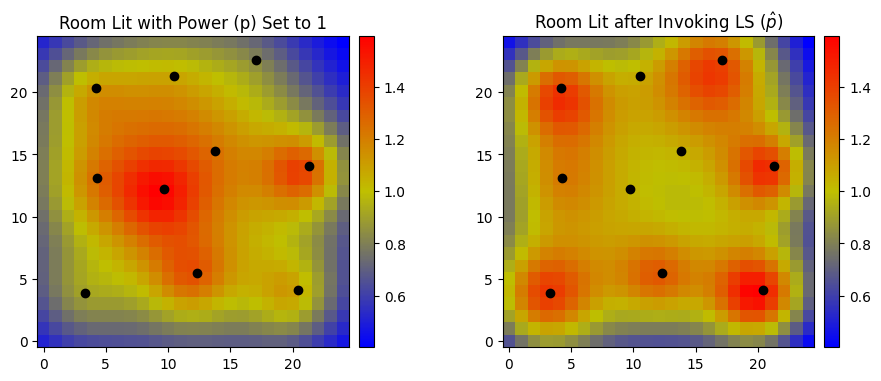

In [ ]:
intensity = [lights, lights2]
title = ['Room Lit with Power (p) Set to 1', 'Room Lit after Invoking LS ($\hat{p}$)']

HeatGraphs(intensity, title, lamps)

<a name="lh"></a>
>>### **Lumen Histograms**

<ipython-input-9-1c9fd2709913>:15: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


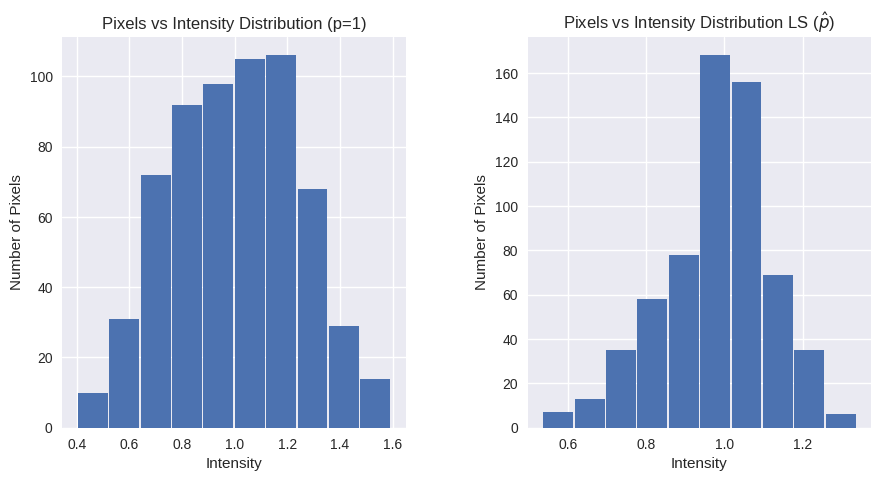

In [ ]:
title = ['Pixels vs Intensity Distribution (p=1)', 'Pixels vs Intensity Distribution LS ($\hat{p}$)']

Histograms(intensity, title)

<a name="e2"></a>
>## **Exercise 2** (Banknote Authenticity Detection)

<a name="sf2"></a>
>>### **Supportive Functions**

In [ ]:
def SplitSet(df):
  '''
  USAGE: to split a dataframe columnwise to A and y
  TODO:
    1.  retreive the A and y
    2.  return A and y to the user
  INPUT:
    @df : the dataframe to split
  OUTPUT:
    the A, y
  '''
  y = df['output'].to_numpy()
  A = np.concatenate((np.ones((y.shape[0], 1)), df.loc[:, df.columns != 'output'].to_numpy()), axis=1)
  return y, A

In [ ]:
def FreqPlot(t1, t2):
  '''
  USAGE:  to create and present the freq distribution of the train & test outputs
  TODO:
    1.  compute the frequencies
    2.  setup the workspace
    3.  create the barplots
    4.  present the plots to the user
  INPUT:
    @t1 : the y_train
    @t2 : the y_test
  OUTPUT:
    a bar plot presenting the distribution in train and test sets
  '''
  #******************************************************
  #******************** COUNTING ************************
  #******************************************************

  #------------------- train set ------------------------
  unique0, count0 = np.unique(t1, return_counts=True)
  h1 = np.asarray((unique0, count0))

  #-------------------- test set ------------------------
  unique1, count1 = np.unique(t2, return_counts=True)
  h2 = np.asarray((unique1, count1))

  #******************************************************
  #******************** PLOTING *************************
  #******************************************************
  X_axis = np.arange(len(unique0))
  plt.style.use('seaborn')
  #------------------- train set ------------------------
  h1 = plt.bar(X_axis - 0.2, count0, 0.4, label = 'Train')
  plt.bar_label(h1, padding=1)
  #-------------------- test set ------------------------
  h2 = plt.bar(X_axis + 0.2, count1, 0.4, label = 'Test')
  plt.bar_label(h2, padding=1)

  #----------------- refining plot ----------------------
  plt.xticks(X_axis, unique0)
  plt.xlabel("Classes")
  plt.ylabel("Frequences")
  plt.title("Frequences in each Class")

  plt.legend()
  plt.show()

In [ ]:
def LS_solution(A, y):
  '''
  USAGE:  to find the least squares classifier's x-coefficients
          using the solution x=(A^T * A)^-1 * A^T * y
  TODO:
    1.  compute the product introduced above
    2.  return the solution to the user
  INPUT:
    @A  : the training set
    @y  : the ground truth
  OUTPUT:
    return the x-coefficient to the user
  '''
  a_trans = np.transpose(A)       # A^T
  a_mul = a_trans @ A             # A^T * A
  a_inv = np.linalg.inv(a_mul)    # (A^T * A)^-1
  a_fin = a_inv @ a_trans         # [(A^T * A)^-1] * A^T
  x = a_fin @ y                   # [(A^T * A)^-1] * A^T * y
  return x

In [ ]:
def Predict(A, xc, a):
  '''
  USAGE: to make predictions
  TODO:
    1.  given A,x multiply and compare the result with the rule:
        "If the prediction value > a then classify the item as 1 otherwise as 0"
    2.  return the predictions
  INPUT:
    @A  : the training set
    @x  : the x-coefficients we have found implementing the LS
    @a  : the given rule to classify
  OUTPUT:
    return the predictions to the user
  '''
  y = pd.Series(A.dot(xc)).apply(lambda x: 1 if x >= a else 0)
  return y

In [ ]:
def DensityDisplay(p, a):
    '''
    USAGE:  to plot the density of the predictions
    TODO:
      1.  create the density plot
      2.  create the threshold
      3.  fine-tuning
      4.  present the plot
    INPUT:
      @p  : our predictions
      @a  : a given threshold
    OUTPUT:
      display the prediction's density
    '''

    d = sns.displot(data = p, x='predicted', hue='groundTruth', kind="kde", fill=True, height=4, aspect=1.5)
    plt.axvline(a, color='r', ls='--', ymax=0.7)
    plt.text(a + 0.03, 0.4, f'threshold $\\alpha$ = {a:.2f}', rotation=90)
    d.set(xlabel='Predictions')

In [ ]:
def ThresholdQuest(cm, A, x, y, a=init_threshold):
  '''
  USAGE: to look for better threshold (a)
  TODO:
    1.  iterate through different values of alpha [0.5,...,0.75]
        * make predictions
        * compute the correct predictions
        * check new predictions if they're better from the last stored, if yes
          change values
        * present the findings (if any)
        * return best values to the user
  INPUT:
    @cm : the confusion matrix from the training set
    @A  : the training set
    @x  : the solution from least squares we found
    @y  : the ground truth
  OUTPUT:
    the findings which include best correct predictions, associated y_pred and opt alpha
  '''
  best = cm.diagonal().sum()
  current_pred = y
  alpha = a
  current_cm = cm

  # iterating alpha values to find best one stepsize 0.01
  for i in np.arange(0.5, 0.75, 0.01):
    # estimating predictions for the training set taking into account the rule:
    #  "If the prediction value > 'running threshold' then classify the item as 1 otherwise as 0"
    y_pred = Predict(A, x, i)

    # get the sum of correct predictions
    new_cm = confusion_matrix(y, y_pred)
    new = new_cm.diagonal().sum()

    # condition: if the new correct predictions > current then modify current values
    if new > best:
      print(f'Former correct predictions: {best}, current best: {new}, new threshold value (alpha): {i:.2f}')
      best = new
      alpha = i
      current_pred = y_pred
      current_cm = new_cm

  print(f'\nOptimal alpha is: {alpha:.2f}')
  return best, current_pred, alpha, current_cm

In [ ]:
def ModelEvaluation(A_tr, A_te, xc, y_tr, y_te, alpha):
  '''
  USAGE:  to evaluate the classifier and plot the results
  TODO:
    1.  evaluate the classifier using the train set (accuracy, error rate)
    2.  evaluate the classifier using the test set (accuracy, error rate)
    3.  print the evaluation results over both sets (accuracy, error rate)
    4.  plot the confusion matrices
  INPUT:
    @A_tr : the train set examples
    @A_te : the test set examples
    @x    : the x-coefficients
    @y_tr : the train set ground truth
    @y_te : the test set ground truth
    @alpha: the threshold
  OUTPUT:
    1.  classifier's metrics
    2.  confusion matrices plots
  '''
  #**********************************************************************
  #*************** ACCURACY & ERROR RATE ESTIMATION *********************
  #**********************************************************************

  #--------------------------- train set --------------------------------
  ytr_pred = Predict(A_tr, xc, alpha)  # prediction using the initial alpha
  cm_tr = confusion_matrix(y_tr, ytr_pred, normalize='true') # confusion matrix
  tn1, fp1, fn1, tp1 = cm_tr.ravel() # extracting metrics

  acc_tr = accuracy_score(y_tr, ytr_pred) # estimating the accuracy
  err_tr = (fp1 + fn1) / (tn1 + fp1 + fn1 + tp1) # estimating the error rate

  #--------------------------- test set --------------------------------
  yte_pred = Predict(A_te, xc, alpha) # prediction using the optimal alpha
  cm_te = confusion_matrix(y_te, yte_pred, normalize='true') # confusion matrix
  tn2, fp2, fn2, tp2 = cm_te.ravel() # extracting metrics

  acc_te = accuracy_score(y_te, yte_pred) # estimating the accuracy
  err_te = (fp2 + fn2) / (tn2 + fp2 + fn2 + tp2) # estimating the error rate

  #------------------------ print findings -----------------------------
  print('--------- train set -----------')
  print(f'Accuracy   : {acc_tr:.2f}')
  print(f'Error rate : {err_tr:.2f}\n')
  print('--------- test set -------------')
  print(f'Accuracy   : {acc_te:.2f}')
  print(f'Error rate : {err_te:.2f}\n\n')

  #**********************************************************************
  #***************** CONFUSION MATRICES PLOTS ***************************
  #**********************************************************************

  fig, axs = plt.subplots(1, 2, figsize=(12,6))

  #----------------- confusion matrix train set -------------------------
  disp1 = ConfusionMatrixDisplay(cm_tr)
  disp1.plot(ax=axs[0], colorbar=False)
  axs[0].set_title(f'Performance using opt $\\alpha$={alpha:.2f} (train set)')
  cax1 = fig.add_axes([axs[0].get_position().x1+0.01, axs[0].get_position().y0, 0.02, axs[0].get_position().height])
  plt.colorbar(disp1.im_,  cax=cax1)

  #----------------- confusion matrix test set ---------------------------
  disp2 = ConfusionMatrixDisplay(cm_te)
  disp2.plot(ax=axs[1], colorbar=False)
  axs[1].set_title(f'Performance using opt $\\alpha$={alpha:.2f} (test set)')
  cax2 = fig.add_axes([axs[1].get_position().x1+0.05, axs[1].get_position().y0, 0.02, axs[1].get_position().height])
  plt.colorbar(disp2.im_,  cax=cax2)

  fig.tight_layout(pad=8.0)
  plt.show()

In [ ]:
def LearningCurves(A_tr, A_te, y_tr, y_te, alpha):
  '''
  USAGE:  to present the learning curves of the model wrt error-rate and accuracy
  TODO:
    1.  create proportional example sizes to feed the model
    2.  iterate through the example sizes:
        * compute the x-coef wrt size
        * evaluate the classifier using the train set (accuracy, error rate)
        * evaluate the classifier using the test set (accuracy, error rate)
        * store each result
    3.  plot error-rate learning curve per size
    4.  plot accuracy learning curve per size
  INPUT:
    @A_tr : the train set examples
    @A_te : the test set examples
    @y_tr : the train set ground truth
    @y_te : the test set ground truth
    @alpha: the threshold
  OUTPUT:
    the learning curves
  '''
  # stating the train sizes to make our estimation.
  # here we divide the train set into 6 training sizes including the total set size
  train_sizes = np.linspace(5, len(train), 6, endpoint=True, dtype=np.int32)

  acc_train = [] # accuracy storage for train set
  err_train = [] # error-rate storage for train set
  acc_test = [] # accuracy storage for test set
  err_test = [] # error-rate storage for test set

  # make error-rate & accuracy estimations wrt size
  for i in train_sizes:
    xc = LS_solution(A_tr[:i][:], y_tr[:i]) # estimate x-coef for the running size
    ytr_pred = Predict(A_tr[:i][:], xc, alpha)  # prediction using the opt alpha
    cm_tr = confusion_matrix(y_tr[:i], ytr_pred) # confusion matrix
    tn1, fp1, fn1, tp1 = cm_tr.ravel() # extracting metrics

    acc_tr = accuracy_score(y_tr[:i], ytr_pred) # estimating the accuracy
    err_tr = (fp1 + fn1) / (tn1 + fp1 + fn1 + tp1) # estimating the error rate
    acc_train.append(acc_tr) # store result
    err_train.append(err_tr) # store result

    #--------------------------- test set --------------------------------
    yte_pred = Predict(A_te, xc, alpha) # prediction using the optimal alpha
    cm_te = confusion_matrix(y_te, yte_pred) # confusion matrix
    tn2, fp2, fn2, tp2 = cm_te.ravel() # extracting metrics

    acc_te = accuracy_score(y_te, yte_pred) # estimating the accuracy
    err_te = (fp2 + fn2) / (tn2 + fp2 + fn2 + tp2) # estimating the error rate
    acc_test.append(acc_te) # store result
    err_test.append(err_te) # store result

  #***********************************************************************
  #************************ PLOTTING CURVES ******************************
  #***********************************************************************
  plt.style.use('seaborn')
  fig, axs = plt.subplots(1, 2, figsize=(12, 5))
  ts = np.linspace(train_sizes.min(), train_sizes.max(), 100)

  #------------------------- error rate ----------------------------------
  # curvy lines code
  spl1 = make_interp_spline(train_sizes, err_train, k=2)
  y_smooth1 = spl1(ts)

  spl2 = make_interp_spline(train_sizes, err_test, k=2)
  y_smooth2 = spl2(ts)

  # lines plotting
  axs[0].plot(ts, y_smooth1, 'r', label='train')
  axs[0].plot(ts, y_smooth2, 'b', label='test')
  axs[0].set_xlabel('Train Sizes')
  axs[0].set_ylabel('error')
  axs[0].set_title('Error-Rate per Train Size')
  axs[0].legend(loc='upper right')
  axs[0].set_xticks(train_sizes)

  #-------------------------- accuracy -----------------------------------
  # curvy lines code
  spl3 = make_interp_spline(train_sizes, acc_train, k=2)
  y_smooth3 = spl3(ts)

  spl4 = make_interp_spline(train_sizes, acc_test, k=2)
  y_smooth4 = spl4(ts)

  # lines plotting
  axs[1].plot(ts, y_smooth3, 'r', label='train')
  axs[1].plot(ts, y_smooth4, 'b', label='test')
  axs[1].set_xlabel('Train Sizes')
  axs[1].set_ylabel('accuracy')
  axs[1].set_title('Accuracy per Train Size')
  axs[1].legend(loc='lower right')
  axs[1].set_xticks(train_sizes)

  plt.suptitle('Learning Curves', fontsize = 20)

In [ ]:
def FeatureEngineering(df):
  '''
  USAGE: to create new features for a set
  TODO:
    1.  iterate through the combination of a dataframe columns:
        * if the first column in a pair is not the same with the other half
          or the inverse pair not exists in the dataframe:
          add a new column in the dataframe containing the product of the pair
          examined
    2.  return the modified dataframe to the user
  INPUT:
    @df : a dataframe
  OUTPUT:
    the modified dataframe
  '''
  for col in df[df.columns[0:4]]:
    for next in df[df.columns[0:4]]:
      if (col != next) and (f'{next}_{col}' not in df.columns):
        df[f'{col}_{next}'] = df[col] * df[next]
  return df

<a name="dt2"></a>
>>### **Data Transformation**

In [ ]:
# obtaining the train data
train = pd.read_csv(train_path, usecols=[1,2,3,4,5])
train.head()

,variance,skewness,kurtosis,entropy,output
0,1.1472,3.59850,1.9387,-0.43406,0
1,-1.7322,-9.28280,7.7190,-1.71680,1
2,-1.1022,-5.83950,4.5641,0.68705,1
3,-1.7063,2.79560,-2.3780,-2.34910,1
4,4.8265,0.80287,1.6371,1.18750,0


In [ ]:
len(train)

1029

In [ ]:
train.iloc[:, 0:4].corr()

,variance,skewness,kurtosis,entropy
variance,1.000000,0.272758,-0.377766,0.262322
skewness,0.272758,1.000000,-0.795881,-0.524273
kurtosis,-0.377766,-0.795881,1.000000,0.314068
entropy,0.262322,-0.524273,0.314068,1.000000


As we can observe from the correlation between the features, there isn't a significant one, exept allegedly the pair skewness-kurtosis we could say; but overall all features can contribute to our model. Graphically, as follows:

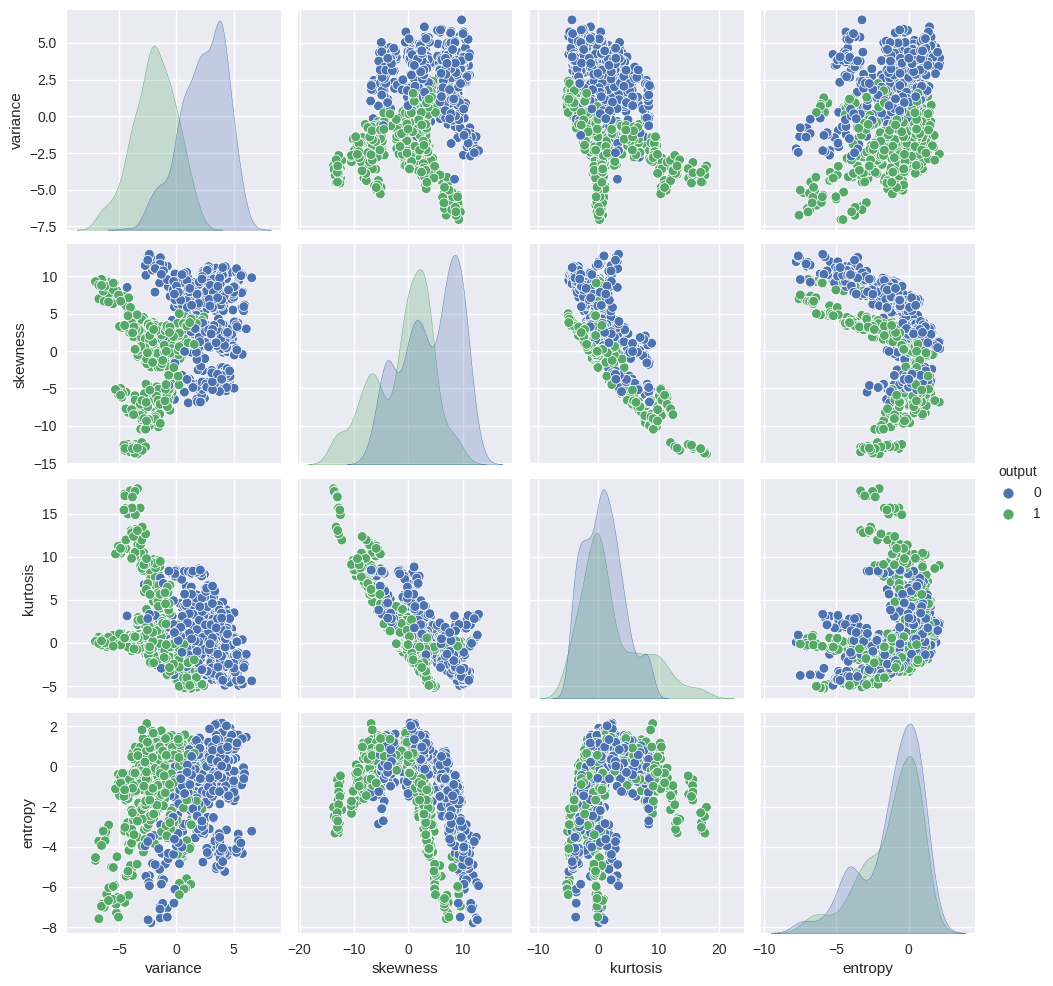

In [ ]:
g = sns.pairplot(train, hue='output')

In [ ]:
# obtaining the test data
d1 = pd.read_csv(test1_path, usecols=[1,2,3,4])
d2 = pd.read_csv(test2_path, usecols=[1])
test = d1.join(d2)
test.head()

,variance,skewness,kurtosis,entropy,output
0,3.86600,-2.6383,1.9242,0.10645,0
1,-1.57680,10.8430,2.5462,-2.93620,0
2,4.43380,9.8870,-4.6795,-3.74830,0
3,-0.38214,8.3909,2.1624,-3.74050,0
4,4.89060,-3.3584,3.4202,1.09050,0


In [ ]:
len(test)

343

<ipython-input-21-9a518aad5531>:31: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


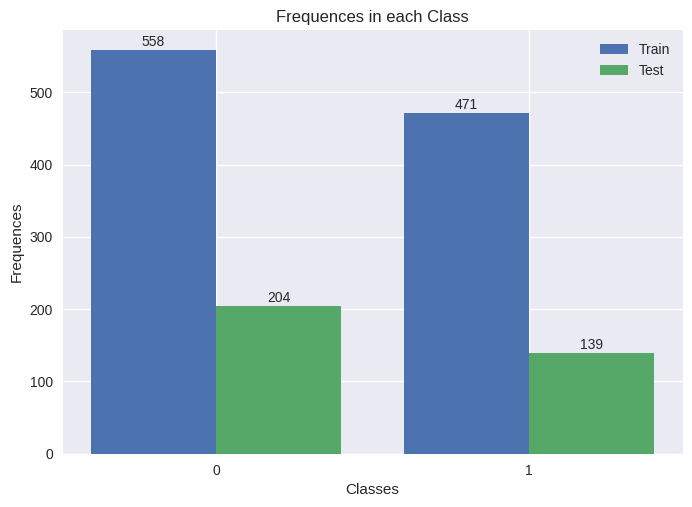

In [ ]:
FreqPlot(train['output'], test['output'])

Our problem must have the form: $Ax=y$, which has the solution $x=\overbrace{(A^TA)^{-1}A^T}^{A^{\dagger}}y$, where $A$ is our training examples and $y$ indicates the class of which each example belongs to. Further more, we are going to add a vector of ones which will indicate us the intersection point (if any) later on.

In [ ]:
# transforming traing set for use
y_train, A_train = SplitSet(train.copy())
print(f'The shape of y_train is: {y_train.shape}')
print(f'The shape of A_train is: {A_train.shape}')

The shape of y_train is: (1029,)
The shape of A_train is: (1029, 5)


In [ ]:
# transforming test set for use
y_test, A_test = SplitSet(test.copy())
print(f'The shape of y_test is: {y_test.shape}')
print(f'The shape of A_test is: {A_test.shape}')

The shape of y_test is: (343,)
The shape of A_test is: (343, 5)


<a name="ls2"></a>
>>### **Least Square Implementation**

In [ ]:
# calculate the x-coefficients using the least square method
x = LS_solution(A_train, y_train)
x.shape, x

((5,),
 array([ 7.94404483e-01, -1.42445381e-01, -7.71582130e-02, -1.01191385e-01,
        -6.23563698e-04]))

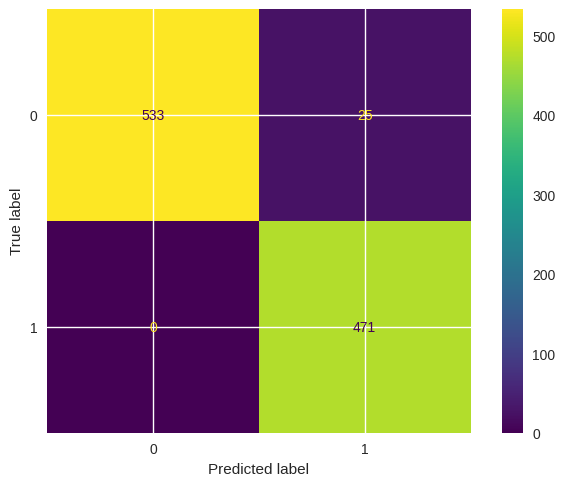

In [ ]:
# estimating predictions for the training set taking into account the rule:
#  "If the prediction value > 0.5 then classify the item as 1 otherwise as 0"
y_pred = Predict(A_train, x, init_threshold)

# creating the confusion matrix for the training set
confMatrix_train = confusion_matrix(y_train, y_pred)

# presenting the confusion matrix
disp = ConfusionMatrixDisplay(confMatrix_train)
disp.plot()

In [ ]:
pred_train = pd.DataFrame({'predicted' : A_train.dot(x), 'groundTruth' : y_train})
pred_train.head()

,predicted,groundTruth
0,0.157428,0
1,0.977367,1
2,0.939697,1
3,1.063853,1
4,-0.121457,0


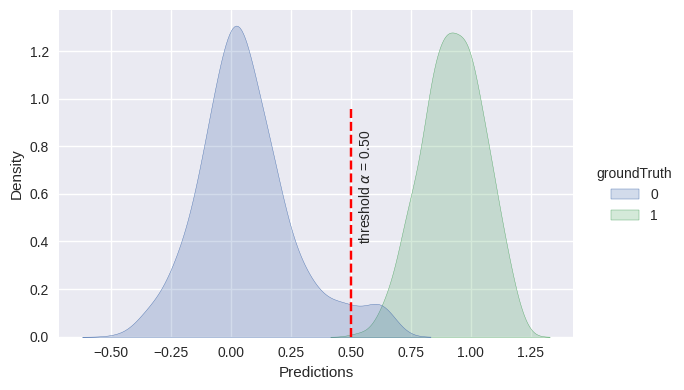

In [ ]:
# where we stand with the training set and the initial threshold alpha (a=0.5)
DensityDisplay(pred_train, 0.5)

From the above diagram we can observe that the optimal threshold lays between 0.5 and 0.75 . So we can do better. Next we are going to try find this value of the threshold.

<a name="tq2"></a>
>>### **Threshold Quest**

In [ ]:
best_correct_pred, best_y_pred, best_alpha, best_cm = ThresholdQuest(confMatrix_train, A_train, x, y_train)

Former correct predictions: 1004, current best: 1007, new threshold value (alpha): 0.53
Former correct predictions: 1007, current best: 1009, new threshold value (alpha): 0.56
Former correct predictions: 1009, current best: 1011, new threshold value (alpha): 0.59
Former correct predictions: 1011, current best: 1014, new threshold value (alpha): 0.61
Former correct predictions: 1014, current best: 1020, new threshold value (alpha): 0.63

Optimal alpha is: 0.63


Now let's see how it performs with the new threshold

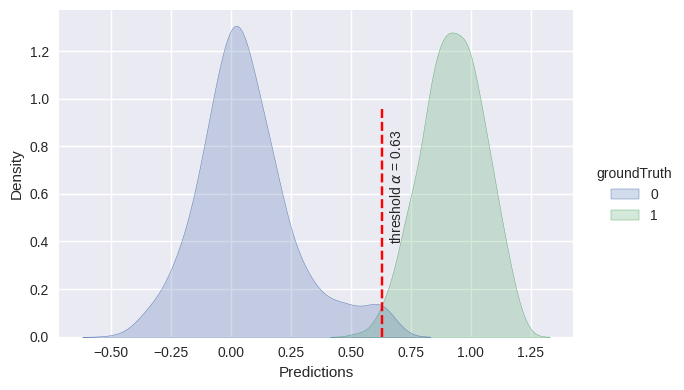

In [ ]:
# where we stand with the training set and the initial threshold alpha (a=0.63)
DensityDisplay(pred_train, best_alpha)

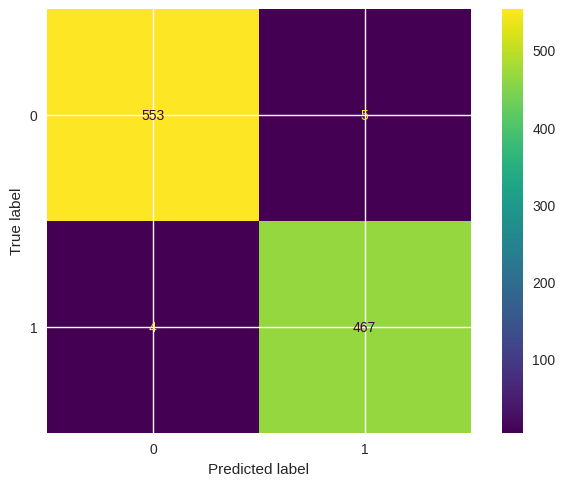

In [ ]:
# presenting the new confusion matrix
disp = ConfusionMatrixDisplay(best_cm)
disp.plot()

As we can observe from the above diagram, it gets much better, but let's see how it performs with the test set.

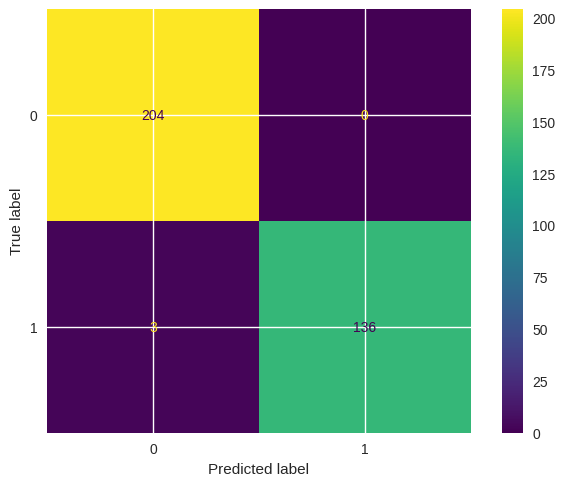

In [ ]:
# estimating predictions for the test set taking into account the rule:
#  "If the prediction value > 0.63 then classify the item as 1 otherwise as 0"
y_pred_test = Predict(A_test, x, best_alpha)

confMatrix_test = confusion_matrix(y_test, y_pred_test)

# presenting the confusion matrix for the test set
disp = ConfusionMatrixDisplay(confMatrix_test)
disp.plot()

In [ ]:
pred_test = pd.DataFrame({'predicted' : A_test.dot(x), 'groundTruth' : y_test})
pred_test.head()

,predicted,groundTruth
0,0.252498,0
1,-0.073437,0
2,-0.124171,0
3,-0.015072,0
4,0.010114,0


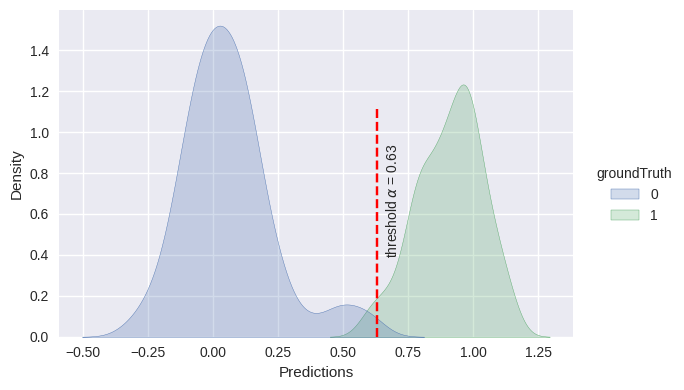

In [ ]:
# where we stand with the training set and the initial threshold alpha (a=0.63)
DensityDisplay(pred_test, best_alpha)

<a name="me2"></a>
>>### **Model Evaluation**

The error rate is given by the formula : $error\_rate = \frac{FP + FN}{N}\thinspace$, ($vmls/p.287\S14.1$)
where :<br/>
* ***FP***: "False Positives",<br/>
* ***FN***: "False Negatives" and <br/>
* ***N***: "Sum of all results (TP, FP, FN, TN)"<br/><br/>



--------- train set -----------
Accuracy   : 0.99
Error rate : 0.01

--------- test set -------------
Accuracy   : 0.99
Error rate : 0.01




<ipython-input-26-b927d31fe636>:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=8.0)


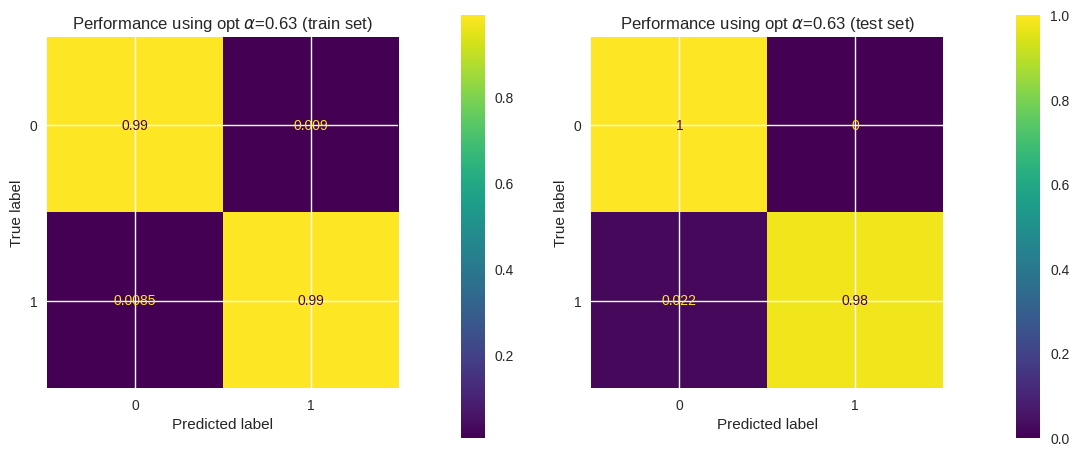

In [ ]:
ModelEvaluation(A_train, A_test, x, y_train, y_test, best_alpha)

<ipython-input-27-c69979594f77>:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


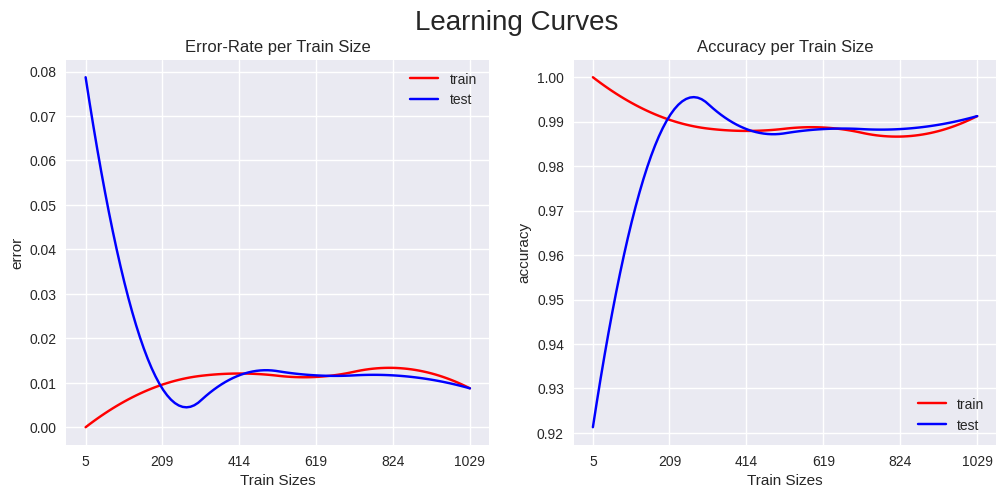

In [ ]:
# plotting the learning curves of the model using opt alpha
LearningCurves(A_train, A_test, y_train, y_test, best_alpha)

From the learning curves we can observe that the model tends to converge  approximately after the $420^{th}$ training size but fluctuating; showing some instability. That means that any icrease in the examples won't contribute further to the model's learning. The error-rate is very low.

<a name="b2"></a>
>>### **Bonus**

According to the $\S13.3$ of the reference book, we can create new features using the existing ones. As a result, we are going to combine the already existing features. In my approach, I will create new features by multiplying each apir of features uniquely.

In [ ]:
# generating new features for the train set
train_b = FeatureEngineering(train.copy())
train_b.shape

(1029, 11)

In [ ]:
train_b.keys()

Index(['variance', 'skewness', 'kurtosis', 'entropy', 'output',
       'variance_skewness', 'variance_kurtosis', 'variance_entropy',
       'skewness_kurtosis', 'skewness_entropy', 'kurtosis_entropy'],
      dtype='object')

In [ ]:
train_b.head()

,variance,skewness,kurtosis,entropy,output,variance_skewness,variance_kurtosis,variance_entropy,skewness_kurtosis,skewness_entropy,kurtosis_entropy
0,1.1472,3.59850,1.9387,-0.43406,0,4.128199,2.224077,-0.497954,6.976412,-1.561965,-0.841512
1,-1.7322,-9.28280,7.7190,-1.71680,1,16.079666,-13.370852,2.973841,-71.653933,15.936711,-13.251979
2,-1.1022,-5.83950,4.5641,0.68705,1,6.436297,-5.030551,-0.757267,-26.652062,-4.012028,3.135765
3,-1.7063,2.79560,-2.3780,-2.34910,1,-4.770132,4.057581,4.008269,-6.647937,-6.567144,5.586160
4,4.8265,0.80287,1.6371,1.18750,0,3.875052,7.901463,5.731469,1.314378,0.953408,1.944056


In [ ]:
# generating new features for the test set
test_b = FeatureEngineering(test.copy())
test_b.shape

(343, 11)

In [ ]:
test_b.keys()

Index(['variance', 'skewness', 'kurtosis', 'entropy', 'output',
       'variance_skewness', 'variance_kurtosis', 'variance_entropy',
       'skewness_kurtosis', 'skewness_entropy', 'kurtosis_entropy'],
      dtype='object')

In [ ]:
test_b.head()

,variance,skewness,kurtosis,entropy,output,variance_skewness,variance_kurtosis,variance_entropy,skewness_kurtosis,skewness_entropy,kurtosis_entropy
0,3.86600,-2.6383,1.9242,0.10645,0,-10.199668,7.438957,0.411536,-5.076617,-0.280847,0.204831
1,-1.57680,10.8430,2.5462,-2.93620,0,-17.097242,-4.014848,4.629800,27.608447,-31.837217,-7.476152
2,4.43380,9.8870,-4.6795,-3.74830,0,43.836981,-20.747967,-16.619213,-46.266216,-37.059442,17.540170
3,-0.38214,8.3909,2.1624,-3.74050,0,-3.206499,-0.826340,1.429395,18.144482,-31.386161,-8.088457
4,4.89060,-3.3584,3.4202,1.09050,0,-16.424591,16.726830,5.333199,-11.486400,-3.662335,3.729728


In [ ]:
# splitting the train set into examples and ground truth
y_train_b, A_train_b = SplitSet(train_b.copy())
print(f'The shape of y_train_b is: {y_train_b.shape}')
print(f'The shape of A_train_b is: {A_train_b.shape}')

The shape of y_train_b is: (1029,)
The shape of A_train_b is: (1029, 11)


In [ ]:
# splitting the test set into examples and ground truth
y_test_b, A_test_b = SplitSet(test_b.copy())
print(f'The shape of y_test_b is: {y_test_b.shape}')
print(f'The shape of A_test_b is: {A_test_b.shape}')

The shape of y_test_b is: (343,)
The shape of A_test_b is: (343, 11)


In [ ]:
# calculate the x-coefficients using the least square method
x_b = LS_solution(A_train_b, y_train_b)
x_b.shape, x_b

((11,),
 array([ 7.93283482e-01, -1.43416656e-01, -8.58787799e-02, -1.14443148e-01,
         2.03938115e-02,  3.99850295e-03, -6.66633012e-03,  4.65042549e-03,
         1.07320283e-03, -2.97744329e-03,  1.95918176e-04]))

In [ ]:
# estimating predictions for the training set taking into account the rule:
#  "If the prediction value > 0.5 then classify the item as 1 otherwise as 0"
y_train_pred_b = Predict(A_train_b, x_b, init_threshold)

# creating the confusion matrix for the training set
confMatrix_train_b = confusion_matrix(y_train_b, y_train_pred_b)

In [ ]:
pred_train_b = pd.DataFrame({'predicted' : A_train_b.dot(x_b), 'groundTruth' : y_train_b})
pred_train_b.head()

,predicted,groundTruth
0,0.100335,0
1,0.960819,1
2,0.984234,1
3,1.008182,1
4,-0.142577,0


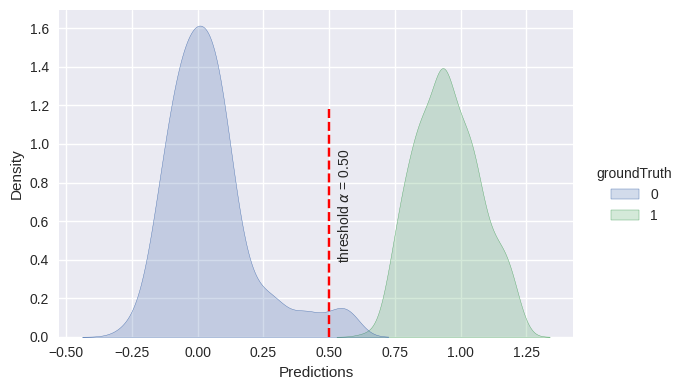

In [ ]:
# where we stand with the training set and the initial threshold alpha (a=0.5)
DensityDisplay(pred_train_b, init_threshold)

In [ ]:
# estimating the optimal threshold alpha
best_correct_pred_b, best_y_pred_b, best_alpha_b, best_cm_b = ThresholdQuest(confMatrix_train_b, A_train_b, x_b, y_train_b)

Former correct predictions: 1008, current best: 1011, new threshold value (alpha): 0.51
Former correct predictions: 1011, current best: 1013, new threshold value (alpha): 0.53
Former correct predictions: 1013, current best: 1017, new threshold value (alpha): 0.54
Former correct predictions: 1017, current best: 1020, new threshold value (alpha): 0.56
Former correct predictions: 1020, current best: 1029, new threshold value (alpha): 0.59

Optimal alpha is: 0.59


--------- train set -----------
Accuracy   : 1.00
Error rate : 0.00

--------- test set -------------
Accuracy   : 1.00
Error rate : 0.00




<ipython-input-26-b927d31fe636>:68: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout(pad=8.0)


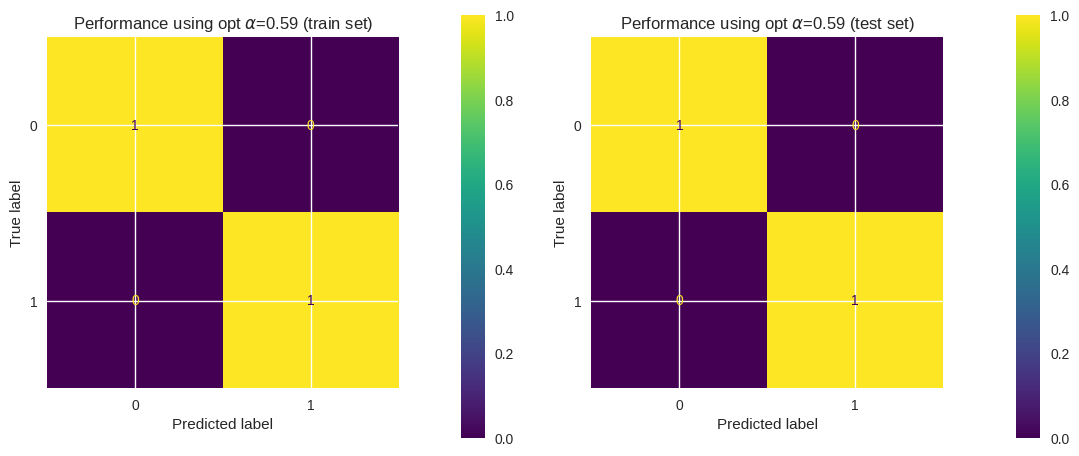

In [ ]:
# evaluating the model using the optimal alpha
ModelEvaluation(A_train_b, A_test_b, x_b, y_train_b, y_test_b, best_alpha_b)

<ipython-input-27-c69979594f77>:56: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


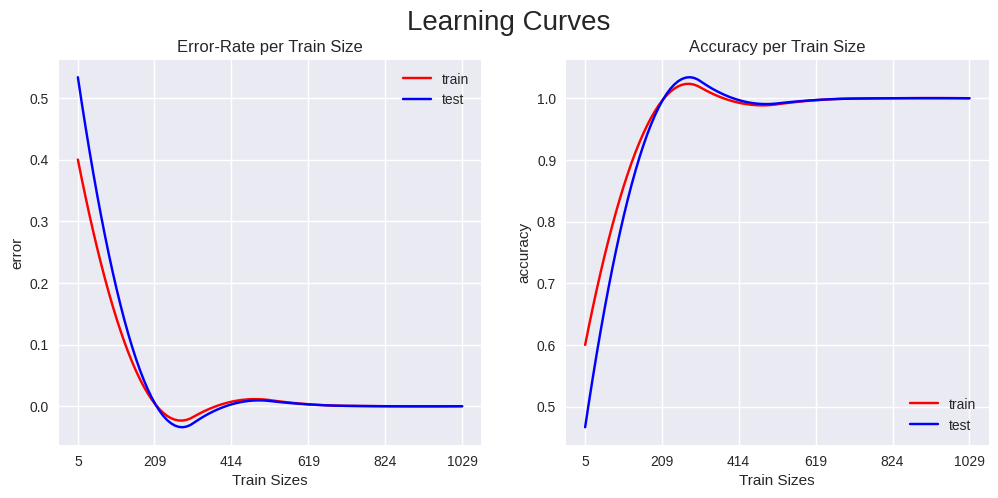

In [ ]:
# plotting the learning curves of the modified model
LearningCurves(A_train_b, A_test_b, y_train_b, y_test_b, best_alpha_b)

From the learning curves we can observe that the enchanced model is converging approximatetly after the $450^{th}$ training size and it's stable. That means that adding more examples won't improve the performance of the model.